In [1]:
#Load Library
import torch
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, SubsetRandomSampler
import seaborn as sns


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Load Data and Get Insight
root_folder = '../input/minerals-identification-dataset/minet'
target_label = ['biotite', 'bornite', 'chrysocolla', 'malachite', 
                'muscovite', 'pyrite', 'quartz']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#load data and tranform it into tensor
dataset = ImageFolder(root_folder, transform=transforms.ToTensor())
print('Data size: ',len(dataset))
dataset.classes

Data size:  956


['biotite',
 'bornite',
 'chrysocolla',
 'malachite',
 'muscovite',
 'pyrite',
 'quartz']

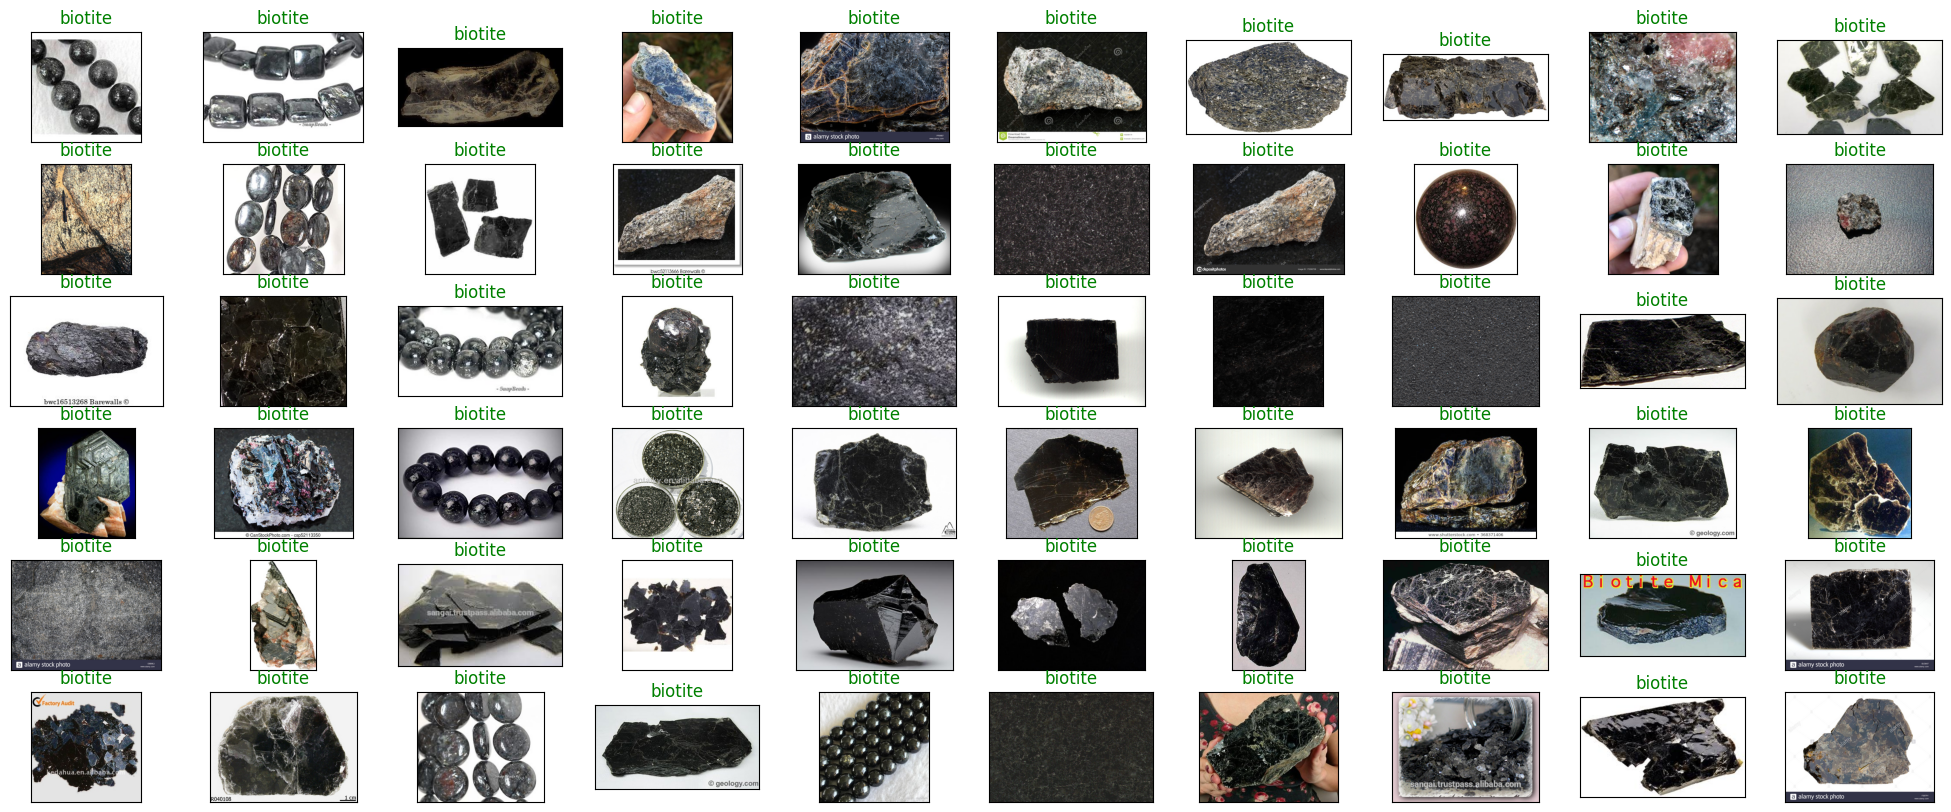

In [4]:
#check images of the dataset for first 20 images
fig = plt.figure(figsize=(25, 10))

for i in range(60):
    image, label = dataset[i]
    ax = fig.add_subplot(6, 10, i+1, xticks=[], yticks = [])
    ax.imshow(image.permute(1,2,0))
    ax.set_title(target_label[label], color='green')

In [5]:
#count number for each label
count = {}

for i in range(len(dataset)):
    _, labels = dataset[i]
    label = target_label[labels]
    if label not in count:
        count[label] = 1
    elif label in count:
        count[label] += 1

#insert count into dataframe
df = pd.DataFrame(count, index=np.arange(1))
df = df.transpose().reset_index()
df.columns = ['Mineral', 'count']
df

Mineral  count
0      biotite     68
1      bornite    170
2  chrysocolla    163
3    malachite    235
4    muscovite     77
5       pyrite     98
6       quartz    145

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


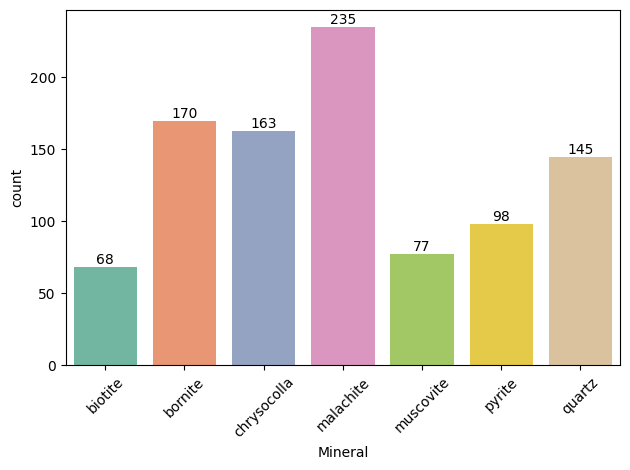

In [6]:
ax = sns.barplot(x='Mineral', y='count', data=df, palette='Set2')

# Add annotations on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

plt.xticks(rotation=45)  # Optional: Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

In [ ]:
#check image size for all datasets
# torch.FloatTensor of shape (C x H x W) 
height = []
weight = []
for i in range(len(dataset)):
    image, label = dataset[i]
    height.append(image.size(1))
    weight.append(image.size(2))
print(f"maximum_height:{np.max(height)} \tminimum_height:{np.min(height)} \tmean_height:{np.mean(height)}")
print(f"maximum_weight:{np.max(weight)} \tminimum_weight:{np.min(weight)} \tmean_weight:{np.mean(weight)}")

maximum_height:6016 	minimum_height:129 	mean_height:696.7426778242677
maximum_weight:6016 	minimum_weight:144 	mean_weight:806.3995815899582


In [8]:
sorted_height = sorted(height)
sorted_height[600]

650

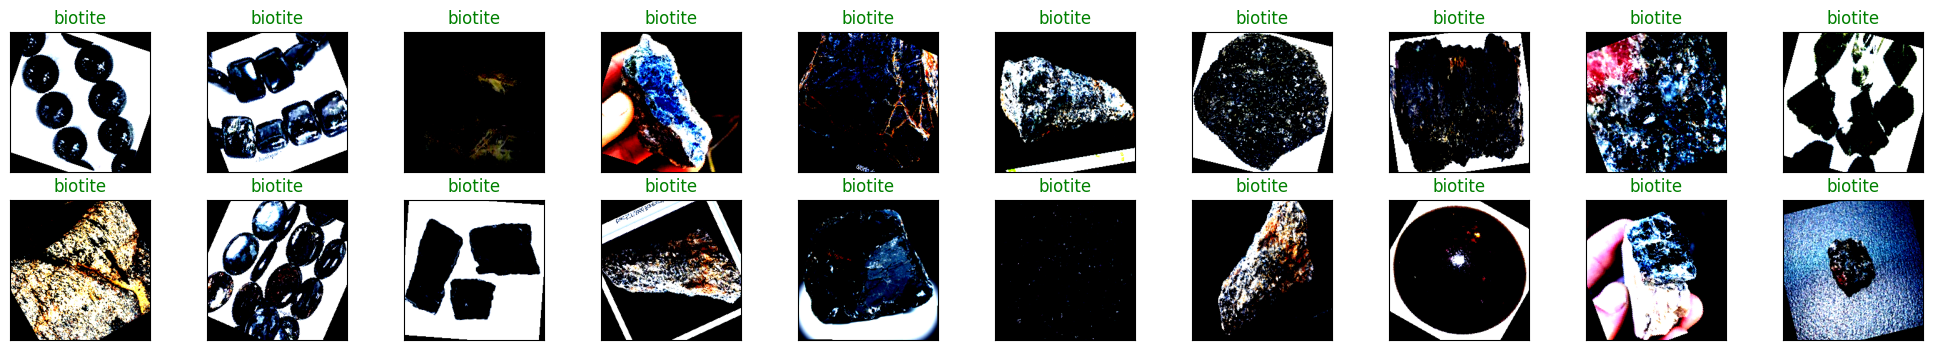

In [ ]:

data_transform = transforms.Compose([transforms.Resize((224, 224)), 
                                     transforms.RandomRotation(30), 
                                     transforms.RandomVerticalFlip(p=0.5),
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])]) #imagenet mean and std

load_data = ImageFolder(root_folder, transform=data_transform)


fig = plt.figure(figsize=(25, 4))
for i in range(20):
    image, label = load_data[i]
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks = [])
    ax.imshow(image.permute(1,2,0))
    ax.set_title(target_label[label], color='green')

In [ ]:
def plot_dist(indexes, dataset=dataset):
    #dist = {}
    count = Counter()
    for i in indexes:
        _, label = dataset[i]
        count[target_label[label]] += 1
    
   

    dist_2 = dict(sorted(count.items(), key=lambda kv: kv[1], reverse=True))
    plt.bar(dist_2.keys(), dist_2.values())
    plt.xticks(rotation=30)
    plt.title('Data distribution'); plt.ylabel('count')
    plt.show()

In [ ]:




idx_label = {}
for i in range(len(dataset)):
    _, label = dataset[i]
    idx_label[i] = label
    

x_train, x_val, y_train, y_val = train_test_split(list(idx_label.keys()), list(idx_label.values()), 
                                                  stratify = list(idx_label.values()), test_size=0.05)

In [ ]:

def bb_split():
    x_train = [id for id in idx_label.keys() if height[id] <= 650]
    y_train =  [ idx_label[i] for i in x_train]
    x_val =  [id for id in idx_label.keys() if height[id] > 650]
    y_val =  [ idx_label[i] for i in x_val]

In [ ]:

x_val
idx_label_2 = {}
for idx, label in idx_label.items():
    if idx not in x_val:
        idx_label_2[idx] = label


x_train, x_test, y_train, y_test = train_test_split(list(idx_label_2.keys()), list(idx_label_2.values()),
                                                    stratify = list(idx_label_2.values()), test_size=0.05)
print(len(x_train))
print(len(x_val))
print(len(x_test))

862
48
46


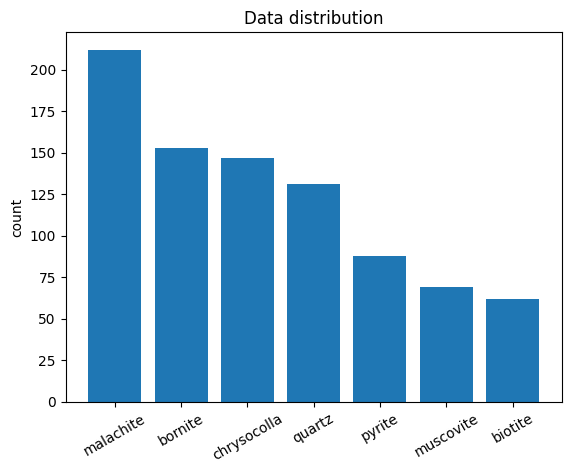

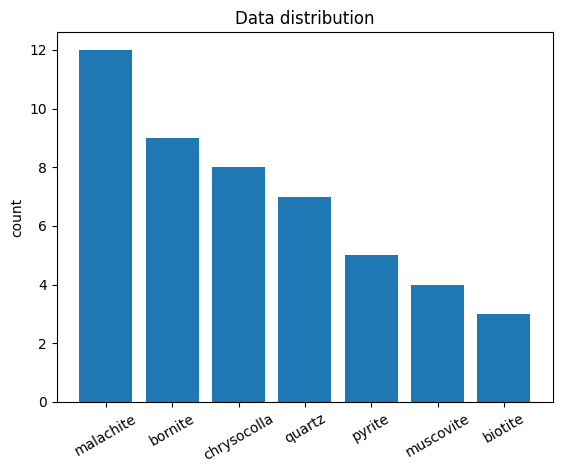

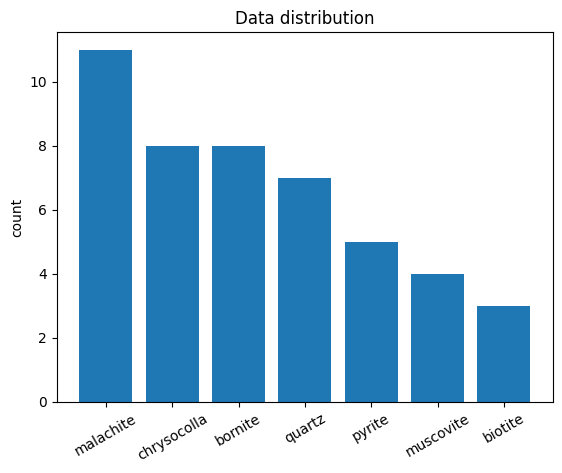

In [15]:
plot_dist(x_train)
plot_dist(x_val)
plot_dist(x_test)

In [ ]:

batch_size = 128


train_set = SubsetRandomSampler(x_train)
val_set = SubsetRandomSampler(x_val)
test_set = SubsetRandomSampler(x_test)

#dataloader
train_loader = DataLoader(load_data, batch_size=batch_size, 
                          shuffle=False, num_workers=0, sampler= train_set)
val_loader = DataLoader(load_data, batch_size=batch_size,  
                        num_workers=0, sampler=val_set)
test_loader = DataLoader(load_data, batch_size=batch_size,
                         num_workers=0, sampler=test_set)

images.shape: torch.Size([128, 3, 224, 224])


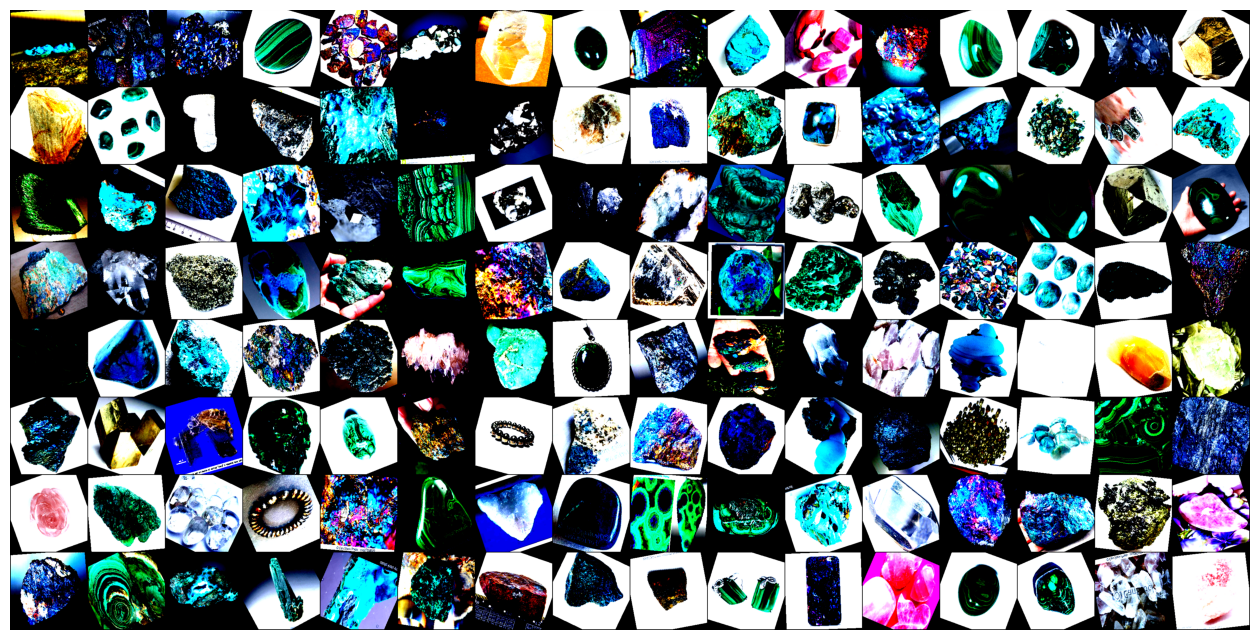

In [17]:
#check image in trainloader for one batch
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,16))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [18]:
#Build Model

#calculation for convnet
w1 = 20
F_SIZE= 3
F_POOL = 3
P = 0
S_SIZE = 1
S_POOL = 3

SIZE = (w1 - F_SIZE + 2*P)/S_SIZE+1 #size after conv
POOL = (SIZE - F_POOL)/S_POOL+1
w1 = POOL #size after pool
print(SIZE)
w1

18.0


6.0

In [19]:
6*6*64

2304

In [ ]:


class Mineral_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 48, 11, stride=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(3, 1), #out 70x70

            nn.Conv2d(48, 128, 5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(3, 1),#out 64x64

            nn.Conv2d(128, 128, 4, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(4, 3),#out 20x20

            nn.Conv2d(128, 64, 3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(3, 3),#out 20x20

            nn.Flatten(),
            nn.Linear(64*6*6, 512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, 7),
            nn.LogSoftmax(dim=1),
            )
        
    def forward(self, x):
        out = self.net(x)
        return out

model_1 = Mineral_1()
model_1.to(device)
model_1

Mineral_1(
  (net): Sequential(
    (0): Conv2d(3, 48, kernel_size=(11, 11), stride=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=2304, out_features=512, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.3, inplace=False)
    (16): Linear(in_features=512, out_features=7, bias=True)
    (17): LogSoftmax(dim=1)
  )
)

In [22]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer):
    train_losses = []
    test_losses = []
    train_accu = []
    val_accu = []
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        train_acc = 0
        for image, label in train_loader:
            optimizer.zero_grad()
            image = image.to(device); label = label.to(device);

            output = model(image)
            ps = torch.exp(output)
            _, top_class = ps.topk(1, dim=1)
            correct = top_class == label.view(*top_class.shape)
            train_acc += torch.mean(correct.type(torch.FloatTensor))

            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            accuracy = 0
            with torch.no_grad():
                for image, label in val_loader:
                    image = image.to(device); label = label.to(device);

                    output = model(image)
                    loss = criterion(output, label)

                    ps = torch.exp(output)
                    _, top_class = ps.topk(1, dim=1)
                    correct = top_class == label.view(*top_class.shape)
                    accuracy += torch.mean(correct.type(torch.FloatTensor))

                    test_loss += loss.item()

            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))
            train_accu.append(train_acc/len(train_loader))
            val_accu.append(accuracy/len(val_loader))
            model.train()
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Train Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(val_loader)),
                  "Train Accuracy: {:.3f}.. ".format(train_acc/len(train_loader)),
                  "Test Accuracy: {:.3f}.. ".format(accuracy/len(val_loader)),
                  "Time: {:.2f}s" .format((time.time()-since)))
    
    history = {'train_loss' : train_losses, 'val_loss': test_losses, 
               'train_accuracy': train_accu, 'val_accuracy':val_accu}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [ ]:

def save_model(model, optim, fpath):
    checkpoint = {'model' : model,
                'state_dict': model.state_dict(),
                'optim' : optim.state_dict()
                }

    torch.save(checkpoint, fpath)


def load_model(fpath, inferece = True):
    check = torch.load(fpath)
    model = check['model']
    model.load_state_dict(check['state_dict'])
    if inferece:
        for param in model.parameters():
            param.requires_grad = False
        model.eval()
    else:
        model.train()
    return model

In [24]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.0001)
epoch = 40
epoch = 5
history_mineral = fit(epoch, model_1, train_loader, val_loader, criterion, optimizer)

Epoch: 1/5..  Train Loss: 1.891..  Test Loss: 1.795..  Train Accuracy: 0.215..  Test Accuracy: 0.250..  Time: 17.93s
Epoch: 2/5..  Train Loss: 1.749..  Test Loss: 1.594..  Train Accuracy: 0.262..  Test Accuracy: 0.375..  Time: 16.35s
Epoch: 3/5..  Train Loss: 1.505..  Test Loss: 1.359..  Train Accuracy: 0.412..  Test Accuracy: 0.500..  Time: 16.31s
Epoch: 4/5..  Train Loss: 1.325..  Test Loss: 1.153..  Train Accuracy: 0.475..  Test Accuracy: 0.500..  Time: 15.88s
Epoch: 5/5..  Train Loss: 1.178..  Test Loss: 0.974..  Train Accuracy: 0.533..  Test Accuracy: 0.646..  Time: 16.18s
Total time: 1.38 m


In [ ]:

save_model(model_1, optimizer, 'mineral_seq_own.pt')

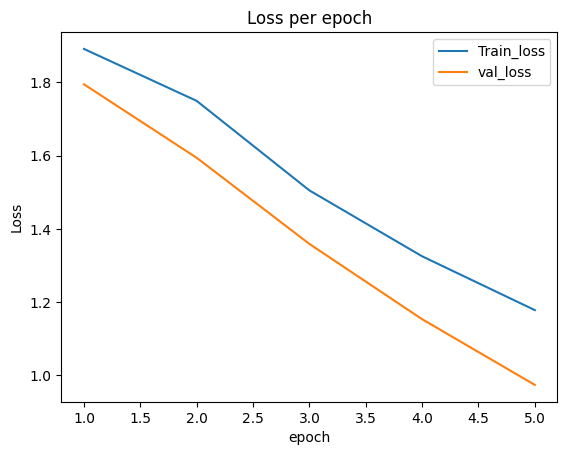

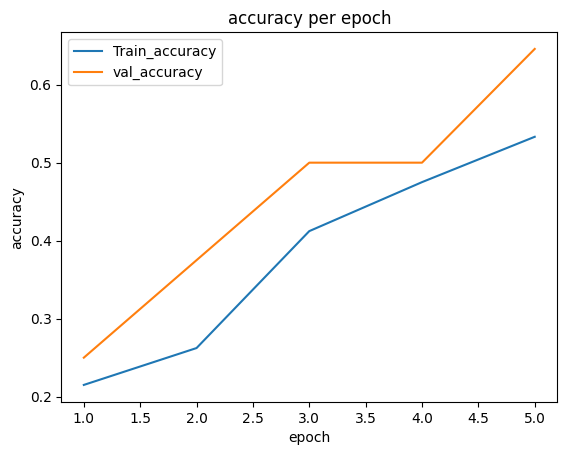

In [26]:
def plot_loss(history, n_epoch):
    epoch = [x for x in range(1, n_epoch+1)]
    plt.plot(epoch, history['train_loss'], label='Train_loss')
    plt.plot(epoch, history['val_loss'], label='val_loss')
    plt.title('Loss per epoch')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(); 
    plt.show()

def plot_accuracy(history, n_epoch):
    epoch = [x for x in range(1, n_epoch+1)]
    plt.plot(epoch, history['train_accuracy'], label='Train_accuracy')
    plt.plot(epoch, history['val_accuracy'], label='val_accuracy')
    plt.title('accuracy per epoch')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(); 
    plt.show()
plot_loss(history_mineral, epoch)
plot_accuracy(history_mineral, epoch)

In [ ]:


from torchvision import models


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import vgg16, VGG16_Weights


weights = VGG16_Weights.DEFAULT
modelVGG= vgg16(weights=weights)


preprocess = weights.transforms()



for param in modelVGG.parameters():
    param.requires_grad = False

#vgg16
modelVGG.classifier = nn.Sequential(nn.Linear(in_features=25088, out_features=4096),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.5),
                                 nn.Linear(in_features=4096, out_features=1000),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.5),
                                 nn.Linear(in_features=1000, out_features=500),
                                 nn.Linear(500, 7),
                                 nn.LogSoftmax(dim=1))




modelVGG.to(device);
modelVGG.train()
modelVGG

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 343MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [28]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(modelVGG.classifier.parameters(), lr=0.0001)
epoch = 40
history_VGG = fit(epoch, modelVGG, train_loader, val_loader, criterion, optimizer)

Epoch: 1/40..  Train Loss: 1.729..  Test Loss: 1.338..  Train Accuracy: 0.318..  Test Accuracy: 0.583..  Time: 17.48s
Epoch: 2/40..  Train Loss: 1.242..  Test Loss: 0.955..  Train Accuracy: 0.579..  Test Accuracy: 0.583..  Time: 17.38s
Epoch: 3/40..  Train Loss: 0.908..  Test Loss: 0.700..  Train Accuracy: 0.661..  Test Accuracy: 0.812..  Time: 17.28s
Epoch: 4/40..  Train Loss: 0.698..  Test Loss: 0.495..  Train Accuracy: 0.753..  Test Accuracy: 0.812..  Time: 17.01s
Epoch: 5/40..  Train Loss: 0.584..  Test Loss: 0.491..  Train Accuracy: 0.796..  Test Accuracy: 0.854..  Time: 17.42s
Epoch: 6/40..  Train Loss: 0.525..  Test Loss: 0.495..  Train Accuracy: 0.818..  Test Accuracy: 0.854..  Time: 17.25s
Epoch: 7/40..  Train Loss: 0.427..  Test Loss: 0.374..  Train Accuracy: 0.857..  Test Accuracy: 0.854..  Time: 16.99s
Epoch: 8/40..  Train Loss: 0.406..  Test Loss: 0.556..  Train Accuracy: 0.865..  Test Accuracy: 0.812..  Time: 17.08s
Epoch: 9/40..  Train Loss: 0.397..  Test Loss: 0.457..  

In [29]:
save_model(modelVGG,  optimizer, 'mineral_vgg.pt')

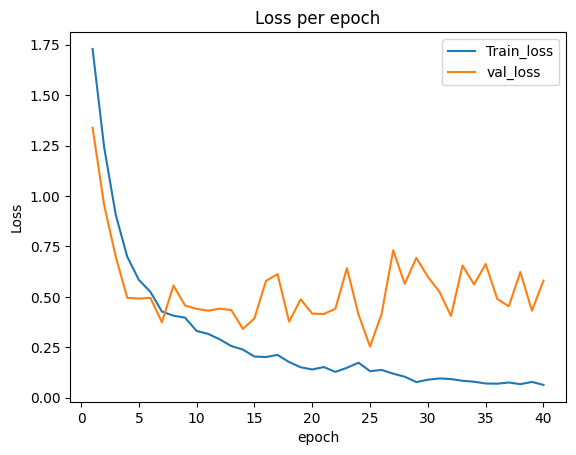

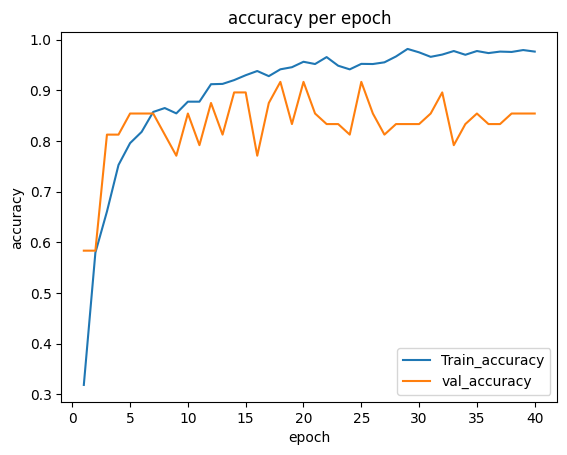

In [30]:
plot_loss(history_VGG, epoch)
plot_accuracy(history_VGG, epoch)

In [31]:
#Prediction and Evaluation

def predict_label(model, dataloader):
    prediction_list = []
    labels = []
    model.to(device)
    model.eval()
    for i, batch in enumerate(dataloader):
        image, label = batch
        image = image.to(device); label = label.to(device)
      
        out = model(image)
        ps = torch.exp(out)
        _, top_class = torch.max(ps , 1)
        preds = np.squeeze(top_class.cpu().numpy())
        prediction_list.append(preds)
        labels.append(label.cpu().numpy())
    return np.squeeze(prediction_list), np.squeeze(labels)

In [ ]:
def predict_plot(test_loader, model, target_label=target_label, n=20):

    
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    images.numpy()

    
    train_on_gpu = torch.cuda.is_available()
    if train_on_gpu:
        images = images.cuda()

    model.eval()
   
    model.to(device)
    output = model(images)
    
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy()) 
    images = images.cpu()

    
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(n):
        ax = fig.add_subplot(2, n//2, idx+1, xticks=[], yticks=[])
        plt.imshow(images[idx].permute(1 ,2, 0))
        ax.set_title("{} ({})".format(target_label[preds[idx]], target_label[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    plt.show()

In [ ]:


model_mineral = load_model('/kaggle/working/mineral_seq_own.pt', inferece=True)
model_mineral

Mineral_1(
  (net): Sequential(
    (0): Conv2d(3, 48, kernel_size=(11, 11), stride=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=2304, out_features=512, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.3, inplace=False)
    (16): Linear(in_features=512, out_features=7, bias=True)
    (17): LogSoftmax(dim=1)
  )
)

In [ ]:

y_predict, y_true = predict_label(model_mineral, test_loader)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.42      0.62      0.50         8
           2       1.00      0.62      0.77         8
           3       0.91      0.91      0.91        11
           4       0.00      0.00      0.00         4
           5       0.30      0.60      0.40         5
           6       0.50      0.57      0.53         7

    accuracy                           0.59        46
   macro avg       0.45      0.48      0.44        46
weighted avg       0.57      0.59      0.56        46



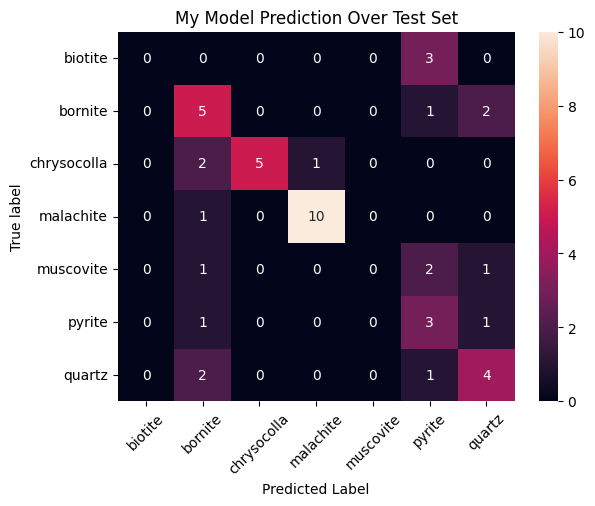

In [ ]:

print(classification_report(y_true, y_predict))
sns.heatmap(confusion_matrix(y_true, y_predict), annot=True)
plt.ylabel('True label'); plt.xlabel('Predicted Label')
plt.yticks(np.arange(0.5, len(target_label)), labels=target_label, rotation=0);
plt.xticks(np.arange(0.5, len(target_label)), labels=target_label, rotation=45)
plt.title('CNN Mmodel Prediction Over Test Set')
plt.show()




In [36]:
#VGG Model

model_vgg = load_model('/kaggle/working/mineral_vgg.pt', inferece=True)

In [37]:
#how model perfome in test_data
y_predict_vgg, y_true_vgg = predict_label(model_vgg, test_loader)

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.62      0.77         8
           2       0.86      0.75      0.80         8
           3       0.79      1.00      0.88        11
           4       0.67      0.50      0.57         4
           5       0.71      1.00      0.83         5
           6       0.83      0.71      0.77         7

    accuracy                           0.80        46
   macro avg       0.80      0.80      0.78        46
weighted avg       0.82      0.80      0.80        46



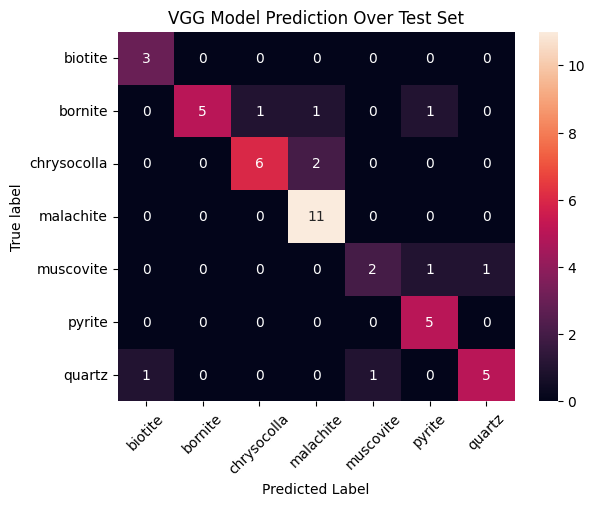

In [38]:
#plot confusion matric
print(classification_report(y_true_vgg, y_predict_vgg))
sns.heatmap(confusion_matrix(y_true_vgg, y_predict_vgg), annot=True)
plt.ylabel('True label'); plt.xlabel('Predicted Label')
plt.yticks(np.arange(0.5, len(target_label)), labels=target_label, rotation=0);
plt.xticks(np.arange(0.5, len(target_label)), labels=target_label, rotation=45)
plt.title('VGG Model Prediction Over Test Set')
plt.show()

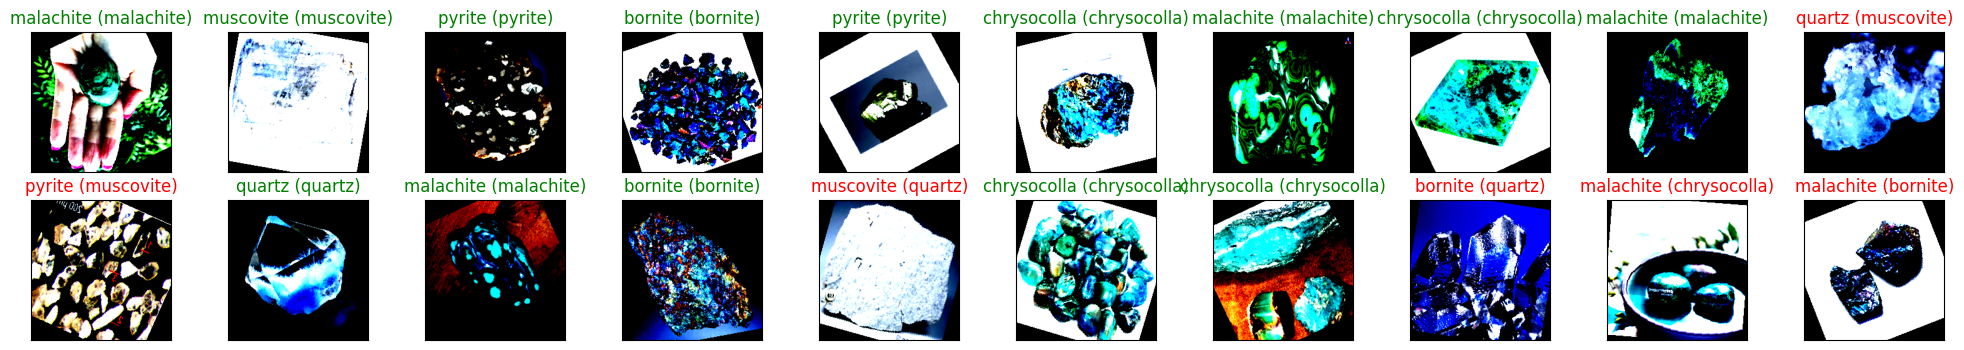

In [39]:
#Plot Prediction
predict_plot(test_loader, model_vgg)

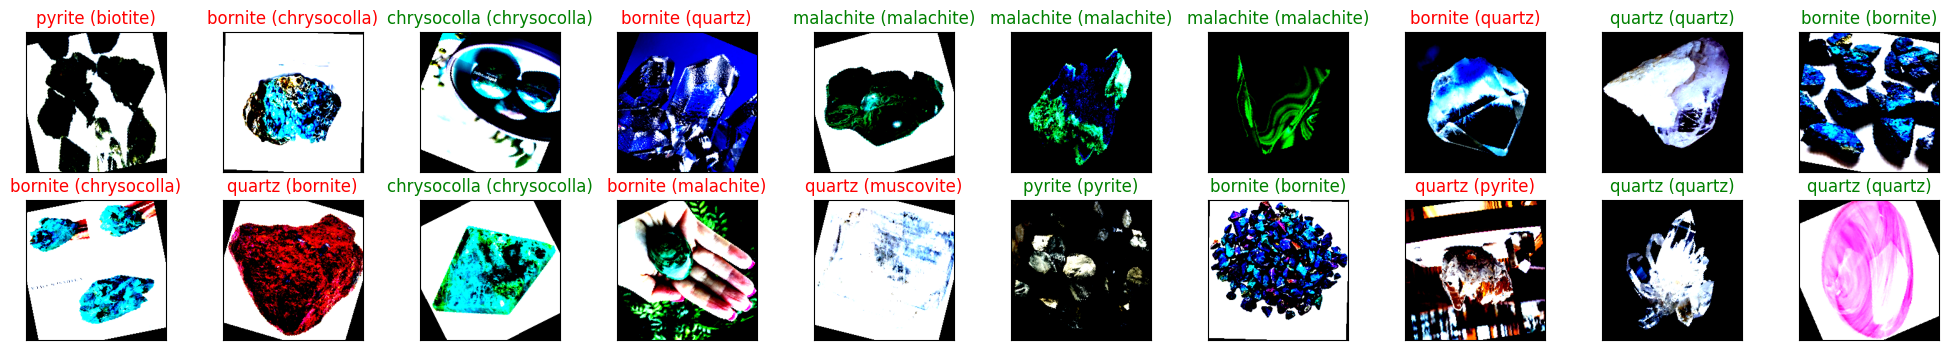

In [40]:
predict_plot(test_loader, model_mineral)